In [76]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.spatial import ConvexHull
from jupyterthemes import jtplot
jtplot.style()

def getAuc(X,y,test_size=0.5,max_depth=None,n_estimators=100,
           minsplit=4,FPR=[],TPR=[],VERBOSE=False, USE_ONLY=None):
    '''
        get AUC given training data X, with target labels y
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    CLASSIFIERS=[DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minsplit),
                RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,min_samples_split=minsplit),
                ExtraTreesClassifier(n_estimators=n_estimators,
                                     max_depth=max_depth,min_samples_split=minsplit,class_weight='balanced'),
                AdaBoostClassifier(n_estimators=n_estimators),
                GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth),
                svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',probability=True)]

    if USE_ONLY is not None:
        if isinstance(USE_ONLY, (list,)):
            CLASSIFIERS=[CLASSIFIERS[i] for i in USE_ONLY]
        if isinstance(USE_ONLY, (int,)):
            CLASSIFIERS=CLASSIFIERS[USE_ONLY]

    for clf in CLASSIFIERS:
        clf.fit(X_train,y_train)
        y_pred=clf.predict_proba(X_test)
        #print(y_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
        auc=metrics.auc(fpr, tpr)
        
        if auc > 0.9:
            fpr_c=fpr
            tpr_c=tpr
            dfa=pd.DataFrame(fpr_c,tpr_c).reset_index()
            dfa.columns=['tpr','fpr']
            dfa[['fpr','tpr']].to_csv('roc_.csv')

        
        if VERBOSE:
            print(auc)

        FPR=np.append(FPR,fpr)
        TPR=np.append(TPR,tpr)
    points=np.array([[a[0],a[1]] for a in zip(FPR,TPR)])
    hull = ConvexHull(points)
    x=np.argsort(points[hull.vertices,:][:,0])
    auc=metrics.auc(points[hull.vertices,:][x,0],points[hull.vertices,:][x,1])
    if auc > 0.825:
        fpr_c=points[hull.vertices,:][x,0]
        tpr_c=points[hull.vertices,:][x,1]
        dfa=pd.DataFrame(fpr_c,tpr_c).reset_index()
        dfa.columns=['tpr','fpr']
        dfa[['fpr','tpr']].to_csv('roc.csv')
        ax=dfa.set_index('fpr').tpr.plot(lw=3,label='tpr')
        ax.set_ylabel('tpr')
        ax.set_title('ROC curve')
    return auc,CLASSIFIERS

## Read data

+ column 1 is diagnosis (1 SCZ vs 2,3,4 other psychosis)
+ 530 SCZ, 54+43+17=114 others


In [82]:
df=pd.read_csv('../PSYCHO.DAT',header=None,index_col=0,sep='\s+')
df=df[df[1]>0]
# X,y for sklearn
X=df.loc[:,2:].values
y=(df.loc[:,1]==1)+0

(0.8504985754985754,
 [RandomForestClassifier(n_estimators=1000),
  ExtraTreesClassifier(class_weight='balanced', n_estimators=1000)])

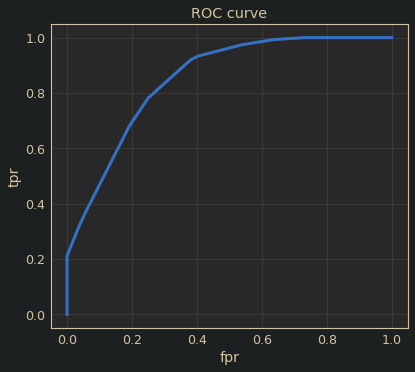

In [79]:
getAuc(X,y,minsplit=2,max_depth=None,n_estimators=1000,USE_ONLY=[1,2])

In [94]:
data=df.copy()
COLS=data.columns
COLS=['i_'+str(x-1) for x in COLS]
COLS[0]='Dx'
data.columns=COLS
data.head()

,Dx,i_1,i_2,i_3,i_4,i_5,i_6,i_7,i_8,i_9,...,i_64,i_65,i_66,i_67,i_68,i_69,i_70,i_71,i_72,i_73
0,,,,,,,,,,,,,,,,,,,,,
1,1,2,2,1,5,1,1,1,1,3,...,1,3,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,3,3,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
5,3,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,0,0,0,0
